In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from mpl_toolkits.mplot3d import axes3d
import scipy.interpolate as interp
from matplotlib import cm
from scipy.interpolate import (
    InterpolatedUnivariateSpline as Spline1d,
    RectBivariateSpline as Spline2d
)
from scipy.interpolate import RectBivariateSpline
from scipy.stats import kurtosis, skew
import scipy.optimize as optimize
from iminuit import Minuit

from ipywidgets import *

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import sncosmo
from sncosmo.salt2utils import BicubicInterpolator

from astropy.table import Table

%matplotlib inline

# Read the data

In [2]:
# file data paths
data_path = ".//SN_surfaces//"
file_names = glob.glob(data_path+"*.dat")
for i in range(0, len(file_names)):
    file_names[i] = file_names[i][15:]
print("Total files in path: ", len(file_names))

Total files in path:  160


# To split the test and train dataset

In [3]:
np.random.seed(42)
sn_train, sn_test = train_test_split(file_names, test_size=0.3)
print(len(sn_train), len(sn_test))

112 48


In [4]:
#Create a log file with training and testing dataset names
f = open(".//log//train_names.txt", 'w')
for i in range(0, len(sn_train)):
    f.write(str(sn_train[i][:-4])+"\n")
f.close()

f = open(".//log//test_names.txt", 'w')
for i in range(0, len(sn_test)):
    f.write(str(sn_test[i][:-4])+"\n")
f.close()

# Training the model

## Principal Component Analysis

In [5]:
TRAIN_DATASET=[]

for i in range(0, len(sn_train)):
    SN = pd.read_csv(".//SN_surfaces//"+str(sn_train[i]),
                           header=None,
                           sep="\s+",
                           names=["phase", "wave", "flux", "eflux"])
    TRAIN_DATASET.append(np.array(SN["flux"]))

In [6]:
TRAIN_DATASET

[array([0.62802   , 0.611381  , 0.593151  , ..., 0.0115822 , 0.00991769,
        0.00832076]),
 array([1.59196e-01, 1.91754e-01, 2.22219e-01, ..., 1.58948e-04,
        1.51234e-04, 1.41736e-04]),
 array([0.097077  , 0.117023  , 0.138044  , ..., 0.00133477, 0.00125739,
        0.00117739]),
 array([2.46391e-01, 2.94884e-01, 3.43337e-01, ..., 1.67086e-03,
        9.43364e-04, 3.19163e-04]),
 array([3.18166e-01, 3.38935e-01, 3.56241e-01, ..., 6.94557e-04,
        4.23930e-04, 1.78449e-04]),
 array([1.11545   , 1.05539   , 0.995102  , ..., 0.00640664, 0.006708  ,
        0.00709616]),
 array([ 0.785135  ,  0.748958  ,  0.712496  , ..., -0.00159054,
        -0.00274557, -0.00387855]),
 array([0.195373  , 0.225282  , 0.257926  , ..., 0.00134249, 0.0011237 ,
        0.0010524 ]),
 array([ 0.400705  ,  0.451533  ,  0.496095  , ..., -0.001004  ,
        -0.00152102, -0.0019598 ]),
 array([0.169497  , 0.16467   , 0.159499  , ..., 0.00197001, 0.00175762,
        0.00154208]),
 array([0.138153  , 

In [7]:
# Number of components
N=10

In [8]:
np.random.random(42)

pca = PCA(N)
pca.fit(TRAIN_DATASET);

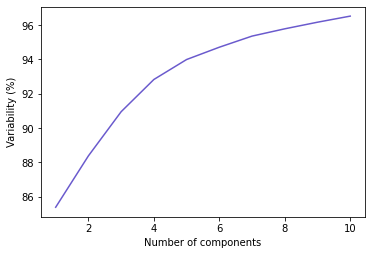

In [9]:
import numpy as np
import matplotlib.pyplot as plt
#plt.rcParams.update({"font.size": 15})

plt.plot(np.linspace(1, 10, 10, dtype=int), np.cumsum(pca.explained_variance_ratio_)*100, color="slateblue")
plt.xlabel('Number of components')
plt.ylabel('Variability (%)')
plt.subplots_adjust(bottom=0.15)
plt.subplots_adjust(left=0.15)

#plt.savefig("/home/joao/Desktop/variabilidade_acumulada.png", dpi = 200)   # save the figure to file

In [10]:
print("Explained variance in 3 components: ", pca.explained_variance_ratio_[0]+pca.explained_variance_ratio_[1]+pca.explained_variance_ratio_[2])

Explained variance in 3 components:  0.9095470928899078


In [11]:
x_grid = np.linspace(-10,50,61)
y_grid = np.linspace(3500,8000, 451)
B1, B2 = np.meshgrid(x_grid, y_grid, indexing='xy')

### Mean surface

<ipython-input-12-61baa158653c>:6: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = axes3d.Axes3D(fig)


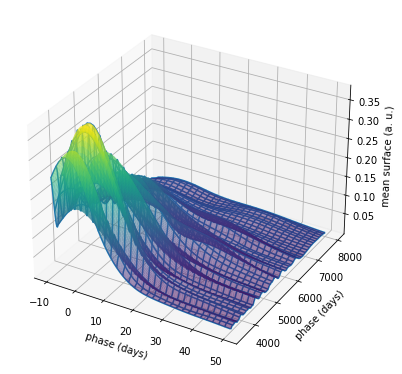

In [12]:
#matplotlib notebook

Z = interp.griddata((SN["phase"],SN["wave"]),pca.mean_,(B1,B2),method='cubic')
#Z = splinemean(B1, B2)
fig = plt.figure(figsize=(7, 5))
ax = axes3d.Axes3D(fig)
ax.plot_wireframe(B1, B2, Z)
ax.plot_surface(B1, B2, Z, cmap=cm.viridis, lw=0.5, rstride=1, cstride=1, alpha=0.6)
ax.set_xlabel("phase (days)")
ax.set_ylabel("phase (days)")
ax.set_zlabel("mean surface (a. u.)")

plt.show()

### Components

In [13]:
optionslist = []

for i in range(0,N):
    
    optionslist.append(i)

<ipython-input-14-b90c7e530708>:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = axes3d.Axes3D(fig)


interactive(children=(Dropdown(description='Component:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0), Out…

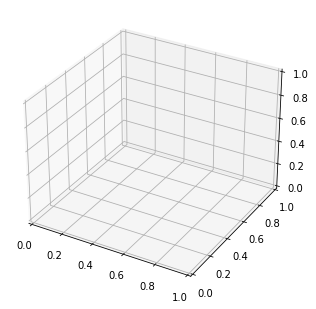

In [14]:
#matplotlib notebook

fig = plt.figure(figsize=(10, 4))
ax = axes3d.Axes3D(fig)

def update_graph(i):
    
    ax.clear()
    
    Z = interp.griddata((SN["phase"],SN["wave"]),pca.components_[i],(B1,B2) ,method='nearest')
    #Z = splinemean(B1, B2)
    #ax.scatter3D(xx,yy,pca.components_[i], c='r')
    ax.plot_wireframe(B1, B2, Z)
    ax.plot_surface(B1, B2, Z, cmap=cm.viridis, lw=0.5, rstride=1, cstride=1, alpha=0.6)
    #ax.set_zlim([0, 0.04])
    ax.set_xlabel("t (dias)")
    ax.set_ylabel("$\lambda$ ($\AA$)")
    ax.set_zlabel("Template (u. a.)")
    ax.dist = 9

    plt.show()
    
i = widgets.Dropdown(options=optionslist, value=0, description='Component:', disabled=False)

widgets.interactive(update_graph,i = i)

In [15]:
TEMP_PHASE_GRID = np.linspace(-10, 50, 61, dtype=int)
TEMP_WAVE_GRID = np.linspace(3500, 8500, 501, dtype=int)

In [16]:
X_GRID = []
Y_GRID = []
for i in range(0, len(TEMP_PHASE_GRID)):
    for j in range(0, len(TEMP_WAVE_GRID)):
        X_GRID.append(TEMP_PHASE_GRID[i])
        Y_GRID.append(TEMP_WAVE_GRID[j])

In [17]:
# Templates dataset

templates = []
for i in range(N):
    data = [np.array(X_GRID), np.array(Y_GRID), (pca.components_[i].reshape(501, 61).T).reshape(1, len(pca.components_[i]))[0]] # to save as a pandas dataframe
    templates.append(pd.DataFrame(np.array(data).T, columns=["phase", "wave", "flux"]))
    
print("number of templates generated: ", len(templates))

number of templates generated:  10


## Mean, Standard Deviation and Skewness

In [18]:
MEAN = np.mean(TRAIN_DATASET, axis=0)
DESVP = np.std(TRAIN_DATASET, axis=0)
SKW = skew(TRAIN_DATASET, axis=0)

STATISTICAL_MOMENTS = [MEAN, DESVP, SKW]

In [19]:
ST_MOM = []
for i in range(3):
    data = [np.array(X_GRID), np.array(Y_GRID), (STATISTICAL_MOMENTS[i].reshape(501, 61).T).reshape(1, len(STATISTICAL_MOMENTS[i]))[0]] # to save as a pandas dataframe
    ST_MOM.append(pd.DataFrame(np.array(data).T, columns=["phase", "wave", "flux"]))
    
print("number of templates generated: ", len(ST_MOM))

number of templates generated:  3


# Generate photometry data

In [20]:
# csp filters using sncosmo
ab = sncosmo.get_magsystem('ab')
csp_filtersname = ["cspg", "cspr", "cspv9844"]
csp_filters = [sncosmo.get_bandpass('cspg'), sncosmo.get_bandpass('cspr'), sncosmo.get_bandpass('cspv9844')]

In [21]:
# photometry grid
PHOTO_XGRID = np.linspace(-10, 45, 16, dtype=int)
WAVE_GRID = np.linspace(3500, 8500, 501, dtype=int)

In [22]:
def function_gen(data, dwave=10, returnfun="on"):
    """
    data: pandas dataframe structured with column names as phase, wave and flux
    dwave: differencial wavelength (defaut 10 angstroms)
    returnfun: variable to define what you will want to return. If on it return function, if off return data values
    """
    
    if returnfun == "on":
        functions = []
        for nn in range(0, len(csp_filters)): # run over filters
            temp_flux = []
            for ii in range(0, len(PHOTO_XGRID)): # for each grid point...
                # integral element
                temp_flux.append(np.sum(data[data["phase"]==PHOTO_XGRID[ii]]["flux"]*csp_filters[nn](WAVE_GRID)*WAVE_GRID*dwave))
            functions.append(Spline1d(PHOTO_XGRID, temp_flux)) # save each function to return (number of functions will be the number of filters)
        return functions

    if returnfun == "off":
        
        temp_phase =[]
        temp_flux = []
        temp_eflux = []
        temp_filter = []
        temp_zp = []
        temp_zpsys = []
        for nn in range(0, len(csp_filters)): # run over filters
            for ii in range(0, len(PHOTO_XGRID)): # for each grid point...
                temp_phase.append(float(PHOTO_XGRID[ii]))
                temp_flux.append(float(np.sum(data[data["phase"]==PHOTO_XGRID[ii]]["flux"]*csp_filters[nn](WAVE_GRID)*WAVE_GRID*dwave)))
                temp_eflux.append(float(np.sum(csp_filters[nn](WAVE_GRID)*WAVE_GRID*dwave*data[data["phase"]==PHOTO_XGRID[ii]]["eflux"])))
                temp_filter.append(str(csp_filtersname[nn]))
                temp_zp.append(2.5*np.log10(ab.zpbandflux(csp_filtersname[nn])))
                temp_zpsys.append("ab")
                temp_data = [temp_phase, temp_flux, temp_eflux, temp_filter, temp_zp, temp_zpsys] # to save as a pandas dataframe
                temp_data = pd.DataFrame(np.array(temp_data).T, columns=["time", "flux", "fluxerr", "band", "zp", "zpsys"]) # collumn names in agreement with sncosmo
        return temp_data

In [23]:
M0_filt = dict({'cspg':function_gen(templates[0])[0],
                'cspr':function_gen(templates[0])[1],
                'cspv9844':function_gen(templates[0])[2]})

M1_filt = dict({'cspg':function_gen(templates[1])[0],
                'cspr':function_gen(templates[1])[1],
                'cspv9844':function_gen(templates[1])[2]})

M2_filt = dict({'cspg':function_gen(templates[2])[0],
                'cspr':function_gen(templates[2])[1],
                'cspv9844':function_gen(templates[2])[2]})

M3_filt = dict({'cspg':function_gen(templates[3])[0],
                'cspr':function_gen(templates[3])[1],
                'cspv9844':function_gen(templates[3])[2]})

M4_filt = dict({'cspg':function_gen(templates[4])[0],
                'cspr':function_gen(templates[4])[1],
                'cspv9844':function_gen(templates[4])[2]})

# Generating Sintetic fotometry on test data

In [24]:
TEST_DATASET=[]

for i in range(0, len(sn_test)):
    SN = pd.read_csv(".//SN_surfaces//"+str(sn_test[i]),
                           header=None,
                           sep="\s+",
                           names=["phase", "wave", "flux", "eflux"])
    TEST_DATASET.append(SN)

In [25]:
PHOTOMETRY_DATASET_TEST = []
for i in range(0, len(TEST_DATASET)):
    PHOTOMETRY_DATASET_TEST.append(Table(data=Table.from_pandas(function_gen(TEST_DATASET[i], returnfun="off")), dtype=[float, float, float, str, float, str]))

# Models Fit

### SALT2

In [26]:
def salt2_fit(data):
    # create a model
    model = sncosmo.Model(source='salt2')
    model.set(z=0, t0=0)
    # run the fit
    result, fitted_model = sncosmo.fit_lc(data, model, ['x0', 'x1', 'c'], modelcov=False)  # bounds on parameters (if any)
    #print("chi^2 minimum/dof (SALT2): ", result.chisq/result.ndof)
    
    #sncosmo.plot_lc(data, model=fitted_model, errors=result.errors);
    
    return fitted_model, result

In [27]:
templates[0]["flux"][15000]

0.0008159080219541331

### Single Expansion Model (Using PCA)

In [28]:
from scipy.interpolate import RectBivariateSpline

class EXP(sncosmo.Source):
    
    _param_names = ['x0', 'x1', 'x2']
    param_names_latex = ['x_0', 'x_1', 'x_2']
    
    
    def __init__(self, phase, wave, flux0, flux1, flux2, name='EXP', version='2021'):

        self.name = name
        self.version = version
        self._phase = phase
        self._wave = wave
        
        self._model_flux0  = BicubicInterpolator(phase, wave, flux0)
        self._model_flux1  = BicubicInterpolator(phase, wave, flux1)
        self._model_flux2  = BicubicInterpolator(phase, wave, flux2)

        self._parameters = np.array([1, 0, 0])  # initial parameters
        

    def _flux(self, phase, wave):
        
        x0, x1, x2 = self._parameters
        #print('flux!')
        return x0 * (self._model_flux0(phase, wave) +  x1 * self._model_flux1(phase, wave) +  x2 * self._model_flux2(phase, wave))

# Light Curve Fits

In [29]:
gridx = np.linspace(-10, 50, 61)
gridy = np.linspace(3500, 8500, 501)

M0_reshape = np.array(templates[0]["flux"]).reshape(61, 501)
M1_reshape = np.array(templates[1]["flux"]).reshape(61, 501)
M2_reshape = np.array(templates[2]["flux"]).reshape(61, 501)
M3_reshape = np.array(templates[3]["flux"]).reshape(61, 501)
c = pd.read_csv(".//Templates//salt2_colour_law_guy2010.dat", header = None, sep = "\s+")
c.columns = ["wave", "ext"]

#exp_mom = EXP_MOM(gridx, gridy, name='EXP_MOM')

## SALT2 x EXP

In [30]:
optionslist = []

for i in range(0,len(PHOTOMETRY_DATASET_TEST)):
    
    optionslist.append(i)

In [31]:
def update_graph(i):
    
    exp = EXP(gridx, gridy, M0_reshape, M1_reshape, M2_reshape, name='EXP')
    model = sncosmo.Model(source=exp)

    model.set(z=0., t0=0)
    
    result_exp, model_exp = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model, ['x0', 'x1', 'x2'], modelcov=False)  # bounds on parameters (if any)
    print("chi^2 minimum/dof (EXP): ", result_exp.chisq/result_exp.ndof)
    model_salt2, result_salt2 = salt2_fit(PHOTOMETRY_DATASET_TEST[i]);
    print(result_salt2)
    sncosmo.plot_lc(PHOTOMETRY_DATASET_TEST[i],
                    model=[model_salt2, model_exp],
                    errors=[result_salt2.errors, result_exp.errors],
                    model_label=["SALT2", "EXP"],
                    color="k")
    
i = widgets.Dropdown(options=optionslist, value=0, description='Component:', disabled=False)
widgets.interactive(update_graph,i = i)

interactive(children=(Dropdown(description='Component:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

### Single Expansion Model (Using PCA) (x0, x1, x2, x3)

In [32]:
from scipy.interpolate import RectBivariateSpline

class EXP4(sncosmo.Source):
    
    _param_names = ['x0', 'x1', 'x2', 'x3']
    param_names_latex = ['x_0', 'x_1', 'x_2', 'x_3']
    
    
    def __init__(self, phase, wave, flux0, flux1, flux2, flux3, name='EXP', version='2021'):

        self.name = name
        self.version = version
        self._phase = phase
        self._wave = wave
        
        self._model_flux0  = BicubicInterpolator(phase, wave, flux0)
        self._model_flux1  = BicubicInterpolator(phase, wave, flux1)
        self._model_flux2  = BicubicInterpolator(phase, wave, flux2)
        self._model_flux3  = BicubicInterpolator(phase, wave, flux3)


        self._parameters = np.array([1, 0, 0, 0])  # initial parameters
        

    def _flux(self, phase, wave):
        
        x0, x1, x2, x3 = self._parameters
        #print('flux!')
        return x0 * (self._model_flux0(phase, wave) +  x1 * self._model_flux1(phase, wave) +  x2 * self._model_flux2(phase, wave) +  x3 * self._model_flux3(phase, wave)) 

## SALT2 x EXP4

In [33]:
optionslist = []

for i in range(0,len(PHOTOMETRY_DATASET_TEST)):
    
    optionslist.append(i)

In [34]:
def update_graph(i):
    
    exp = EXP4(gridx, gridy, M0_reshape, M1_reshape, M2_reshape, M3_reshape, name='EXP')
    model = sncosmo.Model(source=exp)

    model.set(z=0., t0=0)
    
    result_exp, model_exp = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model, ['x0', 'x1', 'x2', 'x3'], modelcov=False)  # bounds on parameters (if any)
    print("chi^2 minimum/dof (EXP): ", result_exp.chisq/result_exp.ndof)
    model_salt2, result_salt2 = salt2_fit(PHOTOMETRY_DATASET_TEST[i]);
    print(result_salt2)
    sncosmo.plot_lc(PHOTOMETRY_DATASET_TEST[i],
                    model=[model_salt2, model_exp],
                    errors=[result_salt2.errors, result_exp.errors],
                    model_label=["SALT2", "EXP"],
                    color="k")
    
i = widgets.Dropdown(options=optionslist, value=0, description='Component:', disabled=False)
widgets.interactive(update_graph,i = i)

interactive(children=(Dropdown(description='Component:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

### Single Expansion Model (Using PCA) (x0, x1, x2, c)

In [35]:
from scipy.interpolate import RectBivariateSpline

class EXP3_LC(sncosmo.Source):
    
    _param_names = ['x0', 'x1', 'x2', 'c']
    param_names_latex = ['x_0', 'x_1', 'x_2', 'c']
    
    
    def __init__(self, phase, wave, flux0, flux1, flux2, LC, name='EXP', version='2021'):

        self.name = name
        self.version = version
        self._phase = phase
        self._wave = wave
        
        self._model_flux0  = BicubicInterpolator(phase, wave, flux0)
        self._model_flux1  = BicubicInterpolator(phase, wave, flux1)
        self._model_flux2  = BicubicInterpolator(phase, wave, flux2)
        #self._model_flux3  = BicubicInterpolator(phase, wave, flux3)
        self._model_ext =  Spline1d(LC['wave'], LC['ext'],  k=1)  

        self._parameters = np.array([1, 0, 0, 0])  # initial parameters
        

    def _flux(self, phase, wave):
        
        x0, x1, x2, c = self._parameters
        #print('flux!')
        return x0 * (self._model_flux0(phase, wave) +  x1 * self._model_flux1(phase, wave) +  x2 * self._model_flux2(phase, wave)) * 10.** (-0.4 * self._model_ext(wave) * c) 

In [36]:
def update_graph(i):
    
    exp = EXP3_LC(gridx, gridy, M0_reshape, M1_reshape, M2_reshape, c, name='EXP')
    model = sncosmo.Model(source=exp)

    model.set(z=0, t0=0)
    
    result_exp, model_exp = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model, ['x0', 'x1', 'x2', 'c'], modelcov=False)  # bounds on parameters (if any)
    print("chi^2 minimum/dof (EXP): ", result_exp.chisq/result_exp.ndof)
    model_salt2, result_salt2 = salt2_fit(PHOTOMETRY_DATASET_TEST[i]);
    print(result_exp)
    sncosmo.plot_lc(PHOTOMETRY_DATASET_TEST[i],
                    model=[model_salt2, model_exp],
                    errors=[result_salt2.errors, result_exp.errors],
                    model_label=["SALT2", "EXP"],
                    color="k")
    
i = widgets.Dropdown(options=optionslist, value=0, description='Component:', disabled=False)
widgets.interactive(update_graph,i = i)

interactive(children=(Dropdown(description='Component:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

In [37]:
def free_parameters(ii):
    """
    i:SN train index
    """
    model_salt2, result_salt2 = salt2_fit(PHOTOMETRY_DATASET_TEST[ii])
    exp = EXP(gridx, gridy, M0_reshape, M1_reshape, M2_reshape, name='EXP')
    model = sncosmo.Model(source=exp)
    model.set(z=0., t0=0)
    result_exp, model_exp = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model, ['x0', 'x1', 'x2'], modelcov=False)
    return result_exp.parameters[2], result_exp.parameters[3], result_exp.parameters[4], result_salt2.parameters[2], result_salt2.parameters[3], result_salt2.parameters[4]

In [38]:
df = pd.DataFrame(data=np.zeros(shape=(len(PHOTOMETRY_DATASET_TEST), 6)), columns=["x0_exp", "x1_exp", "x2_exp", "x0_salt2", "x1_salt2", "c_salt2"])
for i in range(0, len(PHOTOMETRY_DATASET_TEST)):
    x0_exp, x1_exp, x2_exp, x0_salt2, x1_salt2, c_salt2 = free_parameters(i)
    df["x0_exp"][i] = -2.5*np.log10(x0_exp)
    df["x1_exp"][i] = x1_exp
    df["x2_exp"][i] = x2_exp
    df["x0_salt2"][i] = -2.5*np.log10(x0_salt2)
    df["x1_salt2"][i] = x1_salt2
    df["c_salt2"][i] = c_salt2

df.head()

,x0_exp,x1_exp,x2_exp,x0_salt2,x1_salt2,c_salt2
0,16.200745,-0.004749,-0.299546,-10.412894,0.142040,0.051273
1,17.272230,0.062387,-0.120683,-9.138745,1.016078,0.213046
2,15.963347,-0.073469,-0.121175,-10.624340,0.497905,-0.067319
3,16.106418,0.028096,-0.093091,-10.466636,1.855751,-0.023865
4,16.490559,0.022764,-0.272566,-10.128063,-1.750618,0.048524


In [47]:
salt2_param_names = {
    0:"x0_salt2",
    1:"x1_salt2",
    2:"c_salt2"
}

salt2_param_latex = {
    0:"$x_0$",
    1:"$x_1$",
    2:"$c$"
}

exp_param_names = {
    0:"x0_exp",
    1:"x1_exp",
    2:"x2_exp"
}

exp_param_latex = {
    0:"$x_0$",
    1:"$x_1$",
    2:"$x_2$"
}

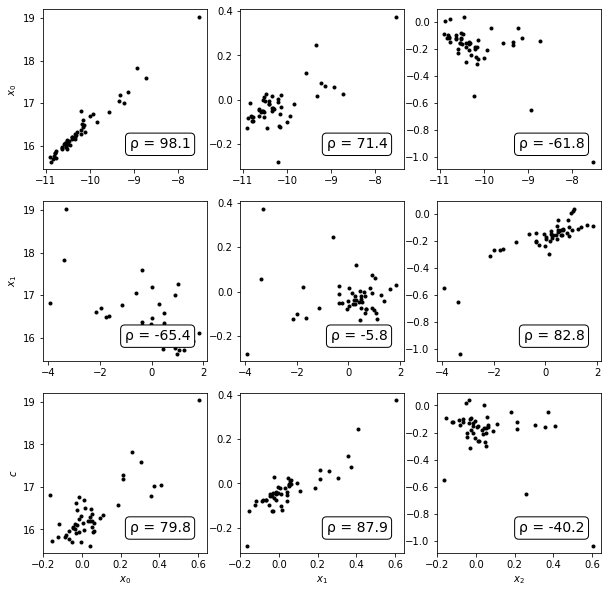

In [95]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(10,10))
for i in range(3):
    for j in range(3):
        ax[i, j].plot(df[salt2_param_names[i]], df[exp_param_names[j]], 'k.', label=str(round(np.corrcoef(df[salt2_param_names[i]], df[exp_param_names[j]])[0][1]*100, 1)))
        ax[i, j].annotate("ρ = "+str(round(np.corrcoef(df[salt2_param_names[i]], df[exp_param_names[j]])[0][1]*100, 1)), xy=(0.9, .2), xycoords='axes fraction',
                          size=14, ha='right', va='top',
                          bbox=dict(boxstyle='round', fc='w'))
        if j == 0:
            ax[i, j].set_ylabel(salt2_param_latex[i])
        if i == 2:
            ax[i, j].set_xlabel(exp_param_latex[j])